In [8]:
from numpy import genfromtxt

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

import matplotlib.pyplot as plt
import arviz as az

# Linear Regression w/ Outliers

This notebook ended up mirroring much of the work in [Dan Foreman-Mackey's blog post](https://dfm.io/posts/intro-to-numpyro/).

Let's again use some synthetic data $(x_i,y_i)$, where $\{x_i\}$ are known with negligible uncertainty, and $\{y_i\}$ values have variable uncertainties $\{\sigma_{yi}\}$.

In [9]:
#data = genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data = genfromtxt('/home/vscode/sci-comp-ii-fall24/data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

In [10]:
def plot_data():
    plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], fmt=",k", ms=0, capsize=0, lw=1)
    plt.scatter(data['x'], data['y'], marker="o", s=5, c="k", label="data")
    plt.xlabel('x')
    plt.ylabel('y')

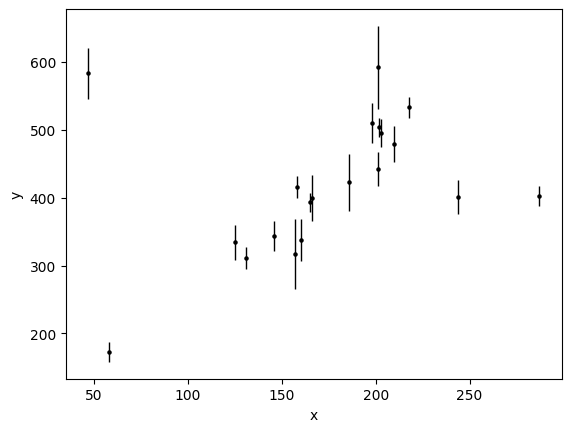

In [11]:
plot_data()

To deal with outliers we need to define a *generative model* for both the good data (foreground) and the bad (background).  Each datum can either be from the foreground or the background, and since we don't know *a priori*, we need to introduce discrete parameters $q_i$, ($x_i$ and $y_i$ here) where $q_i=0$ indicates datum $i$ is background, and $q_i=1$ if foreground.  We'll need to infer the probablility $P_b$ that any particular datum is part of the background.  Since we need a generative model for the background, let's assume it's normally distributed with mean and standard deviation $\mu_b$ and $\sigma_b$, independent of $x$.

We have now added $N+3$ extra parameters $(\{q_i\}_{i=1}^N, P_b, \mu_b, \sigma_b)$ to deal with outliers, and the likelihood takes the form

$$
\mathcal{L} = p\left(\{y_i\}_{i=1}^N|m,b,\{q_i\}_{i=1}^N,\mu_b,\sigma_b,I\right)
$$
I is the prior
or, broken down into foreground and background

$$
\mathcal{L} = \prod_i \left[p_\mathrm{fg}(\{y_i\}|m,b,I)\right]^{q_i} \left[p_\mathrm{bg}(\{y_i\}|\mu_b, \sigma_b, I)\right]^{1-q_i},
$$

where

$$
p_\mathrm{fg} = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}} \exp \left(-\frac{(y_i - mx_i - b)^2}{2\sigma_{yi}^2}\right) \\
p_\mathrm{bg} = \frac{1}{\sqrt{2\pi(\sigma_b^2 + \sigma_{yi}^2})} \exp \left(-\frac{(y_i - \mu_b)^2}{2(\sigma_b^2 +\sigma_{yi}^2)}\right)
$$

Since we are specifying a probability $P_b$ of each data point being an outlier, we need to incorporate this binomial probability in our prior

$$
p(m,b,\{q_i\},P_b,\mu_b,\sigma_b|I) = p(\{q_i\}|P_b,I)p(m,b,P_b,\mu_b,\sigma_b|I)
$$

where $p(\{q_i\}|P_b,I)$ is the binomial probability

$$
p(\{q_i\}|P_b,I) = \prod_i \left(1 - P_b\right)^{q_i}P_b^{1-q_i}
$$

We could sample in the (very) high-dimensional space, sampling both the continuous variables and the discrete ones.  However, we can also _marginalize_ over the $\{q_i\}$'s analytically, and save our MCMC some work.

Focusing on our likelihood

$$
p\left(\{y_i\}_{i=1}^N|m,b,\{q_i\}_{i=1}^N,\mu_b,\sigma_b\right) = \prod_i p(y_i|m,b,q_i,\mu_b,\sigma_b),
$$

we can integrate over (actually sum, since it's discrete) the unknown $q_i$'s to account for their uncertainty.  To do so we need to specify our prior $p(q_i)$ and we are left with:

$$
p\left(\{y_i\}_{i=1}^N|m,b,\{q_i\}_{i=1}^N,\mu_b,\sigma_b\right) = \prod_i \left [p(q_i=0) p(y_i|m,b,\mu_b,\sigma_b, q_i=0) + p(q_i=1) p(y_i|m,b,\mu_b,\sigma_b, q_i=1)\right],
$$

which is a _mixture model_!

## Foreground-only Model

First let's repeat our previous analysis that assumed all data to be from the foreground model, i.e., following the linear relationship.  Before we let numpyro's Normal distribution implicitly vectorize the likelihood, which assumes each data point to be independent.  In general, the way to tell numpyro that values along a particular dimensions should be treated independently is to use a _plate_.  We'll use that here.

In [12]:
def linear_model(x=None, y=None, σ_y=None):
    # priors
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 500))

    # define the mean of the normal distribution
    μ = m * x + b

    # Likelihood
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(μ, σ_y), obs=y)

In [13]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=data['x'],
         y=data['y'],
         σ_y=data['sigm_y'])
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b    213.98     13.88    214.30    189.98    235.28    340.51      1.00
         m      1.07      0.07      1.07      0.94      1.19    342.68      1.00

Number of divergences: 0


In [14]:
samples = mcmc.get_samples()
samples

{'b': Array([208.88861, 205.9008 , 206.78453, ..., 222.84851, 211.45569,
        244.13135], dtype=float32),
 'm': Array([1.1244617, 1.113848 , 1.1128939, ..., 1.0610474, 1.066504 ,
        0.92356  ], dtype=float32)}

In [15]:
samples['b'].shape

(2000,)

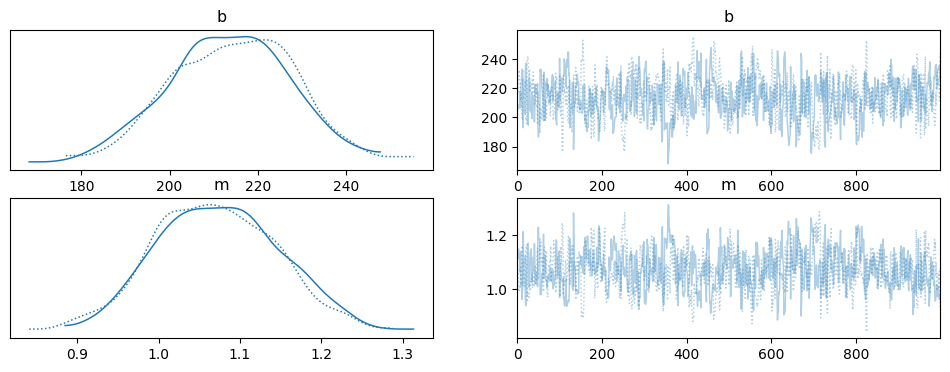

In [16]:
az.plot_trace(mcmc);

Let's look at the lines corresponding to a few posterior draws to get a sense of the uncertainty in the line we're fitting.

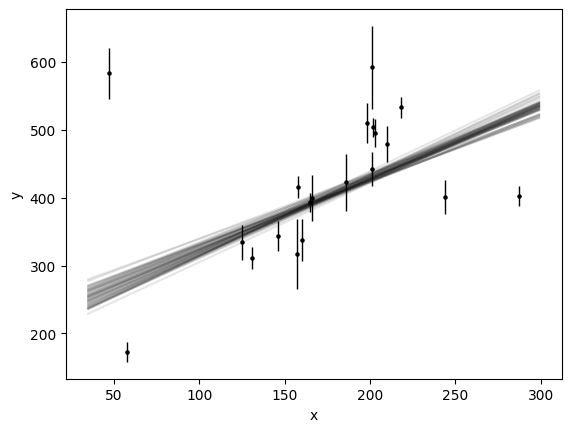

In [17]:
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)


for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='k', alpha=0.1);

Before improving our model, let's exercise one of numpyro superpowers, which is _predictive_ sampling, either by sampling our prior, or _posterior predictive sampling_, where we "predict" the observations based on our posterior estimates of the model parameters. 

In [18]:
post_pred_samples = infer.Predictive(linear_model, samples)(
    random.PRNGKey(1), x=data['x'], σ_y=data['sigm_y']
)
post_pred_y = post_pred_samples["y"]
post_pred_y.shape

(2000, 20)

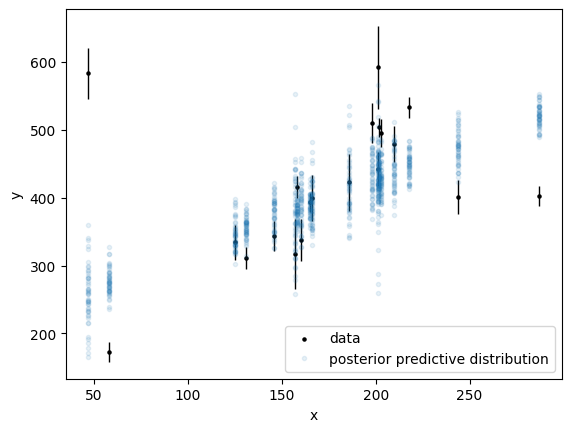

In [19]:
plot_data()

label = "posterior predictive distribution"
for i in random.choice(rng_key, len(post_pred_y), (50,)):
    plt.plot(data['x'], post_pred_y[i], ".", color="C0", alpha=0.1, label=label)
    label = None
plt.legend(loc="lower right");


This makes it painfully obvious that our model is _not_ a good descriptor of the data.

## Foreground and Background Model

In [20]:
import jax

In [21]:
def linear_model_w_outliers(x=None, y=None, σ_y=None):
    # First let's construct our foreground (i.e., linear) model
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 500))
    μ_fg = m * x + b
    dist_fg = dist.Normal(μ_fg, σ_y)

    # Now lets define a model for the background (i.e., outliers)
    μ_bg = numpyro.sample('μ_bg', dist.Normal(loc=400, scale=500))
    σ_bg = numpyro.sample('σ_bg', dist.HalfNormal(scale=500))
    dist_bg = dist.Normal(μ_bg, jnp.sqrt(σ_bg**2 + σ_y**2))

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [22]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model_w_outliers)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=data['x'],
         y=data['y'],
         σ_y=data['sigm_y'])
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      P_fg      0.72      0.13      0.73      0.53      0.93   5055.54      1.00
         b     34.56     17.89     33.67      2.43     59.85   3754.00      1.00
         m      2.24      0.11      2.25      2.07      2.43   3681.90      1.00
      μ_bg    448.45     84.49    447.17    325.49    568.47   2476.04      1.00
      σ_bg    138.51    102.54    109.09     30.37    255.18   2387.56      1.00

Number of divergences: 0


/home/vscode/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


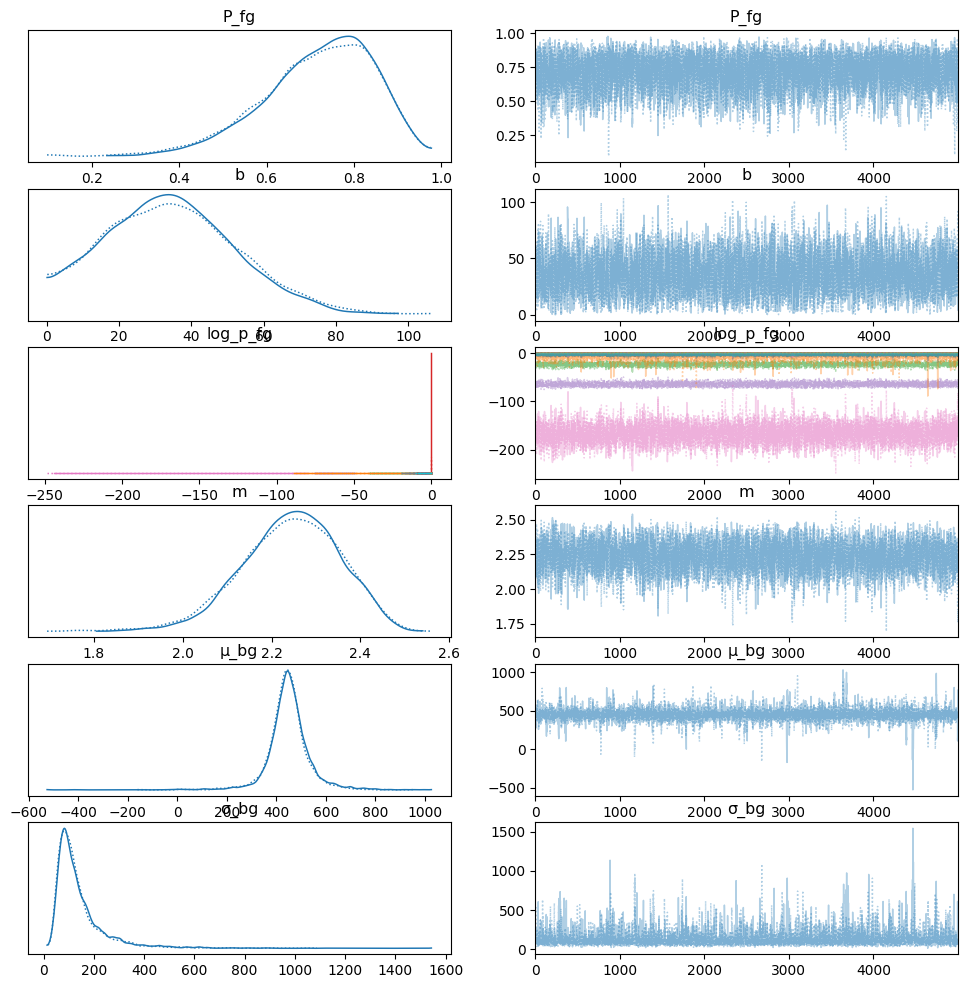

In [23]:
az.plot_trace(mcmc);

In [24]:
samples = mcmc.get_samples()
samples

{'P_fg': Array([0.8817777 , 0.7763723 , 0.76892865, ..., 0.56616133, 0.3376857 ,
        0.63699585], dtype=float32),
 'b': Array([44.693794, 41.491467, 30.787659, ..., 84.29992 , 91.52609 ,
        76.75309 ], dtype=float32),
 'log_p_fg': Array([[[-1.08020782e-01, -2.27895737e+00],
         [-2.29487591e+01,  0.00000000e+00],
         [-6.13457642e+01,  0.00000000e+00],
         ...,
         [-2.43926048e-02, -3.72565603e+00],
         [-1.20856762e-02, -4.42176247e+00],
         [-3.27825546e-02, -3.43420792e+00]],
 
        [[-2.65055180e-01, -1.45741844e+00],
         [-2.39978065e+01,  0.00000000e+00],
         [-6.30174217e+01,  0.00000000e+00],
         ...,
         [-3.70941162e-02, -3.31278229e+00],
         [-2.54683495e-02, -3.68302345e+00],
         [-4.88948822e-02, -3.04243565e+00]],
 
        [[-3.86353970e-01, -1.13796568e+00],
         [-2.01749725e+01,  0.00000000e+00],
         [-6.65383911e+01,  0.00000000e+00],
         ...,
         [-5.80878258e-02, -2.87469912

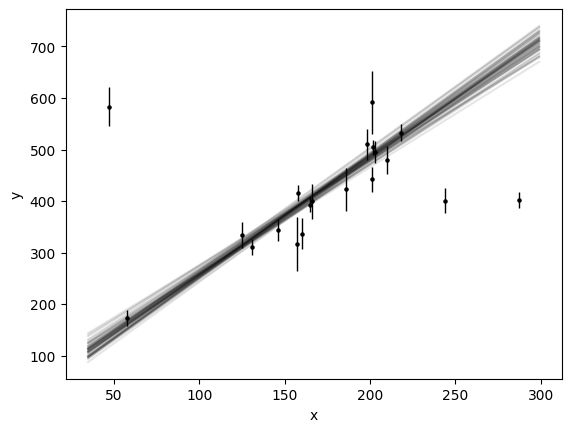

In [25]:
plot_data()

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)

for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='k', alpha=0.1);

Let's take a look at the distribution probabilities of each point being in the foreground.

From the samples we get a complete posterior distribution for the probability of each data point's classification.  Let's look at the distribution of that quantity for two specific points in the data set.

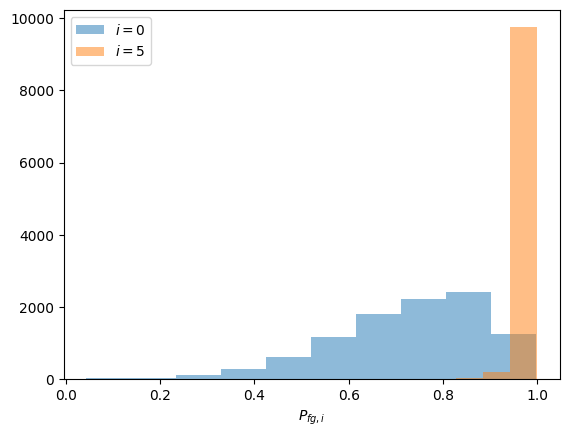

In [26]:
p_fg = jnp.exp(samples["log_p_fg"][..., 0]) # Get the probabilities for the first of the two components (i.e., the foreground)
plt.hist(p_fg[:, 0], label='$i=0$', alpha=0.5) # Plot for the first data point
plt.hist(p_fg[:, 5], label='$i=5$', alpha=0.5) # ...and the sixth
plt.xlabel("$P_{fg,i}$")
plt.legend();

To visualize with the full data set, let's summarize the probabilities by taking the mean and standard deviation over the posterior samples.

In [27]:
p_fg = jnp.mean(jnp.exp(samples["log_p_fg"][..., 0]), axis=0)
σ_p_fg = jnp.std(jnp.exp(samples["log_p_fg"][..., 0]), axis=0)

p_fg.shape

(20,)

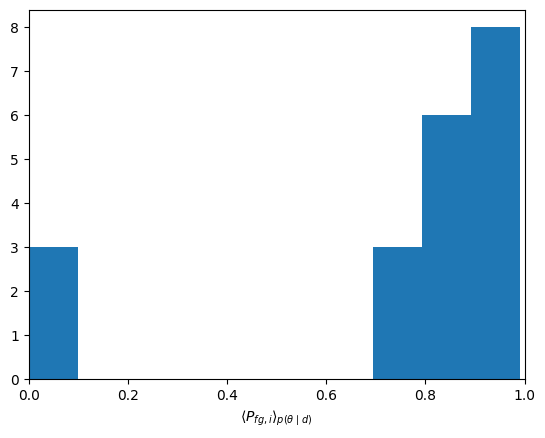

In [28]:
plt.hist(p_fg)
plt.xlabel(r"$\left<P_{fg,i}\right>_{p(\theta\mid d)}$")

plt.xlim(0, 1);

...and encode that in a color channel of a scatter plot.

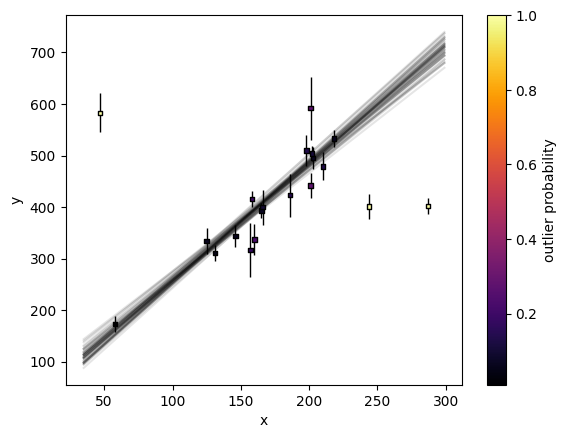

In [29]:
plot_data()

for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='k', alpha=0.1);

plt.scatter(data['x'], data['y'], marker="s", s=10, c=1 - p_fg, zorder=99, edgecolor="k", cmap="inferno")
plt.colorbar(label="outlier probability");

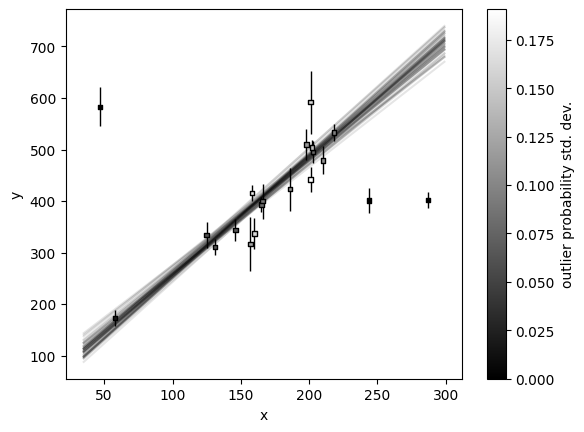

In [30]:
plot_data()

for i in random.choice(rng_key, num_samples, (50,)):
    mu = samples['m'][i] * x + samples['b'][i]
    plt.plot(x, mu, color='k', alpha=0.1);

plt.scatter(data['x'], data['y'], marker="s", s=10, c=σ_p_fg, zorder=99, edgecolor="k", cmap="gray")
plt.colorbar(label="outlier probability std. dev.");